# Generative Adversarial Networks

GANs were first reported in 2014. They have the capability to generate new samples similar to the data they were trained on. For example, creating new faces after being trained on large datasets of faces.

We'll build two networks, a generator and a discriminator. The idea is that we are training a generator to produce samples that the discriminator compares against a sample of real data. Eventually, the generator is able to fool the discriminator into passing a generated sample as real.

The coding is essentially really simple; the real thing is tuning the hyperparameters and the training time involved.

- Discriminator overpowering Generator:

If the discriminator classifies all examples as fake, there is no progress. You may want to have discriminator ouput be unscaled instead of sigmoid.

- Generator overpowering Discriminator: Mode Collapse

The generator discovers some weakness in the discriminator, and the generator ends up producing a similar example regardless of variation in input. You can try adjusting the training rate or changing layers of the discriminator in an attempt to make it better.

GANs are so powerful, they are limited by the hardware that you are using.



# Generate numbers based off the MNIST dataset

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

In [5]:
mnist = input_data.read_data_sets("../03-Convolutional-Neural-Networks/MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


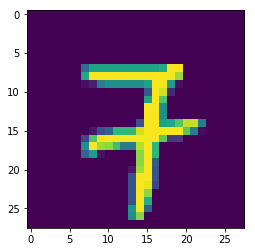

In [12]:
plt.imshow(mnist.train.images[14].reshape(28, 28));

In [13]:
# Generator
def generator(z, reuse=None):
    # gen for generator. The goal is to allow to have modular sections of parameters.
    with tf.variable_scope('gen', reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z, units=128)
        
        # leaky relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1, hidden1)
        
        # second layer, same thing
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        
        # output
        output = tf.layers.dense(hidden2, units=784, activation=tf.nn.tanh)
        
        return output      
        
        

In [15]:
# Discriminator
def discriminator(z, reuse=None):
    # dis for discriminator. The goal is to allow to have modular sections of parameters.
    with tf.variable_scope('dis', reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z, units=128)
        
        # leaky relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1, hidden1)
        
        # second layer, same thing
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        
        # output
        logits = tf.layers.dense(hidden2, units=1) # probability of being real/fake
        output = tf.sigmoid(logits)
        
        return output, logits

In [16]:
# Real Images
real_images = tf.placeholder(tf.float32, shape=[None, 784])

# Noise
z = tf.placeholder(tf.float32, shape=[None, 100])

# Generator and Discriminator
G = generator(z)
D_output_real, D_logits_real = discriminator(real_images)

In [17]:
D_output_fake, D_logits_fake = discriminator(G, reuse=True)

In [18]:
# Losses
def loss_function(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in, labels=labels_in))

In [19]:
D_real_loss = loss_function(D_logits_real, tf.ones_like(D_logits_real)*0.9) # I want all elements to be REAL (times smoothing factor 0.9)

D_fake_loss = loss_function(D_logits_fake, tf.zeros_like(D_logits_real))

D_loss = D_real_loss + D_fake_loss

In [20]:
G_loss = loss_function(D_logits_fake, tf.ones_like(D_logits_fake))

In [21]:
learning_rate = 0.001

In [22]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

In [23]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)